In [1]:
import os
import numpy as np

from PIL import Image
import requests
from io import BytesIO

import math

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import functional as F
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid

import random

from tqdm import tqdm

In [2]:
SEED = 1834579290

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Conf:
    scaling_factor = 4
    x_patch_size = 24
    y_patch_size = scaling_factor * x_patch_size

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

class SRResNet(nn.Module):
    def __init__(self, num_channels=3, num_blocks=16, upscale_factor=4):
        super(SRResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True)
        )

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_blocks)]
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.upscale = nn.Sequential(
            nn.Conv2d(64, 64 * upscale_factor, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(int(np.sqrt(upscale_factor))),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64 * upscale_factor, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(int(np.sqrt(upscale_factor))),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, num_channels, kernel_size=9, stride=1, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        residual = self.res_blocks(x)
        x = self.conv2(residual) + x
        x = self.upscale(x)
        x = self.conv3(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SRResNet(num_channels=3, num_blocks=16, upscale_factor=Conf.scaling_factor).to(device)

In [6]:
model.load_state_dict(torch.load('/kaggle/input/srgan-paper-implementation/SRGAN.pth', map_location=device))

<ipython-input-6-a540eb453451>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/srgan-paper-implementation/SRGAN.pth', map_lo

<All keys matched successfully>

In [7]:
def inference(model, url):
    y_patch_size = Conf.y_patch_size
    scaling_factor = Conf.scaling_factor
    stride = int(y_patch_size * 0.5)
    response = requests.get(url)
    img_hr = Image.open(BytesIO(response.content)).convert("RGB")
    to_tensor = transforms.ToTensor()
    hr_tensor_01 = to_tensor(img_hr).unsqueeze(0)
    _, c, H, W = hr_tensor_01.shape
    hr_tensor = hr_tensor_01 * 2.0 - 1.0

    def generate_indices(size, patch_size, stride):
        indices = list(range(0, size - patch_size, stride))
        if (indices[-1] + patch_size) < size:
            indices.append(size - patch_size)
        return indices

    x_indices = generate_indices(H, y_patch_size, stride)
    y_indices = generate_indices(W, y_patch_size, stride)

    HR_sum = torch.zeros((1, c, H, W), dtype=torch.float32, device=hr_tensor.device)
    HR_count = torch.zeros((1, c, H, W), dtype=torch.float32, device=hr_tensor.device)
    H_lr = H // scaling_factor
    W_lr = W // scaling_factor
    LR_sum = torch.zeros((1, c, H_lr, W_lr), dtype=torch.float32, device=hr_tensor.device)
    LR_count = torch.zeros((1, c, H_lr, W_lr), dtype=torch.float32, device=hr_tensor.device)
    SR_sum = torch.zeros((1, c, H, W), dtype=torch.float32, device=hr_tensor.device)
    SR_count = torch.zeros((1, c, H, W), dtype=torch.float32, device=hr_tensor.device)

    def bicubic_resize(tensor, out_h, out_w):
        return torch.nn.functional.interpolate(tensor, size=(out_h, out_w), mode='bicubic', align_corners=True)

    model.eval()
    with torch.no_grad():
        for xi in x_indices:
            for yi in y_indices:
                hr_patch = hr_tensor[:, :, xi:xi+y_patch_size, yi:yi+y_patch_size]
                HR_sum[:, :, xi:xi+y_patch_size, yi:yi+y_patch_size] += hr_patch
                HR_count[:, :, xi:xi+y_patch_size, yi:yi+y_patch_size] += 1
                hr_patch_01 = (hr_patch + 1) / 2.0
                hr_patch_01 = torch.clamp(hr_patch_01, 0, 1)
                lr_patch_size = y_patch_size // scaling_factor
                lr_patch = bicubic_resize(hr_patch_01, lr_patch_size, lr_patch_size)
                Xo_lr = xi // scaling_factor
                Yo_lr = yi // scaling_factor
                LR_sum[:, :, Xo_lr:Xo_lr+lr_patch_size, Yo_lr:Yo_lr+lr_patch_size] += lr_patch
                LR_count[:, :, Xo_lr:Xo_lr+lr_patch_size, Yo_lr:Yo_lr+lr_patch_size] += 1
                lr_patch_device = lr_patch.to(hr_tensor.device)
                sr_patch = model(lr_patch_device)
                SR_sum[:, :, xi:xi+y_patch_size, yi:yi+y_patch_size] += sr_patch
                SR_count[:, :, xi:xi+y_patch_size, yi:yi+y_patch_size] += 1

    HR_count[HR_count == 0] = 1
    final_hr = HR_sum / HR_count
    LR_count[LR_count == 0] = 1
    final_lr = LR_sum / LR_count
    SR_count[SR_count == 0] = 1
    final_sr = SR_sum / SR_count

    sr_display = torch.clamp((final_sr + 1) / 2.0, 0, 1)
    hr_display = torch.clamp((final_hr + 1) / 2.0, 0, 1)

    lr_img = transforms.ToPILImage()(final_lr.squeeze(0).cpu())
    sr_img = transforms.ToPILImage()(sr_display.squeeze(0).cpu())
    hr_img = transforms.ToPILImage()(hr_display.squeeze(0).cpu())

    lr_w, lr_h = lr_img.size
    sr_w, sr_h = sr_img.size
    hr_w, hr_h = hr_img.size

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(lr_img)
    axs[0].set_title(f"Low-Resolution (LR) {lr_h}x{lr_w}")
    axs[0].axis('off')
    axs[1].imshow(sr_img)
    axs[1].set_title(f"Super-Resolved (SR) {sr_h}x{sr_w}")
    axs[1].axis('off')
    axs[2].imshow(hr_img)
    axs[2].set_title(f"High-Resolution (HR) {hr_h}x{hr_w}")
    axs[2].axis('off')
    plt.show()

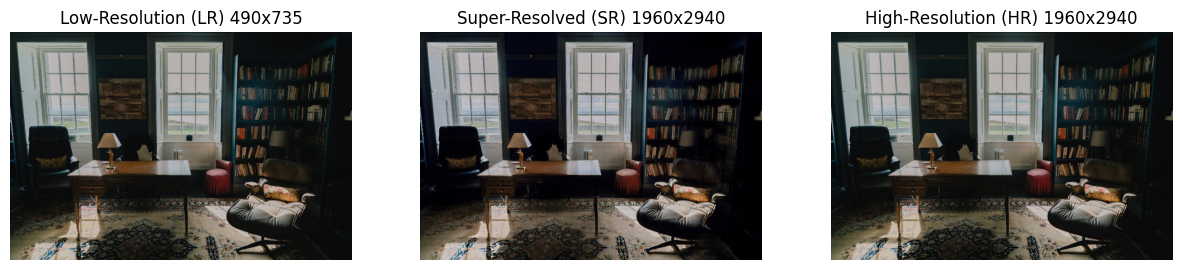

CPU times: user 4min 10s, sys: 2.34 s, total: 4min 12s
Wall time: 2min 8s


In [8]:
%%time

inference(model, "https://images.unsplash.com/photo-1730982045412-326c81810ace?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")

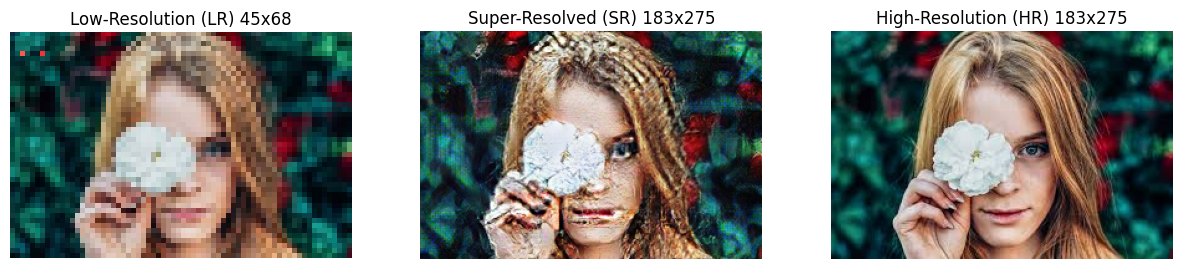

CPU times: user 2.24 s, sys: 155 ms, total: 2.39 s
Wall time: 2.08 s


In [9]:
%%time

inference(model, "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-oTId7rULXRC8rmjdOK19GSwe5vqnVoQSoQ&s")

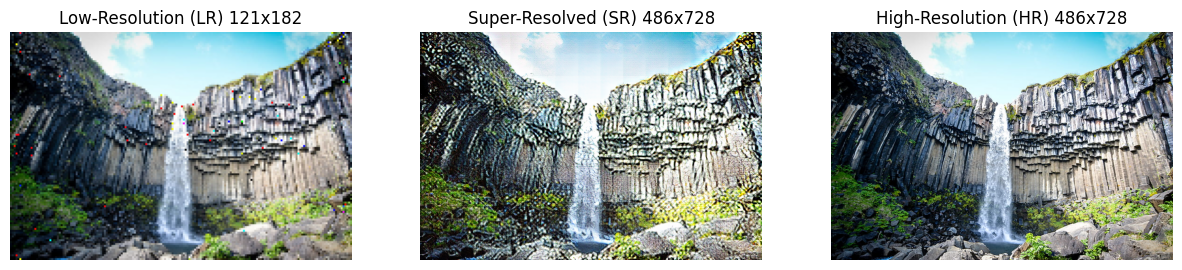

CPU times: user 15.8 s, sys: 247 ms, total: 16.1 s
Wall time: 9.6 s


In [10]:
%%time

inference(model, "https://i1.pickpik.com/photos/53/426/510/waterfall-stream-water-nature-preview.jpg")

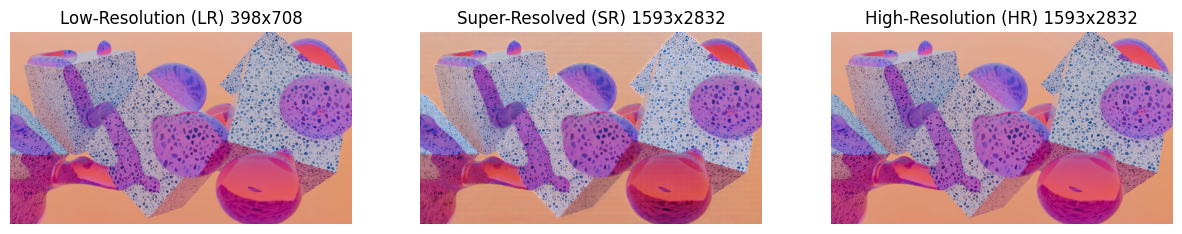

CPU times: user 3min 19s, sys: 1.59 s, total: 3min 20s
Wall time: 1min 42s


In [11]:
%%time

inference(model, "https://images.unsplash.com/photo-1731429945593-61610daebc11?q=80&w=2832&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")

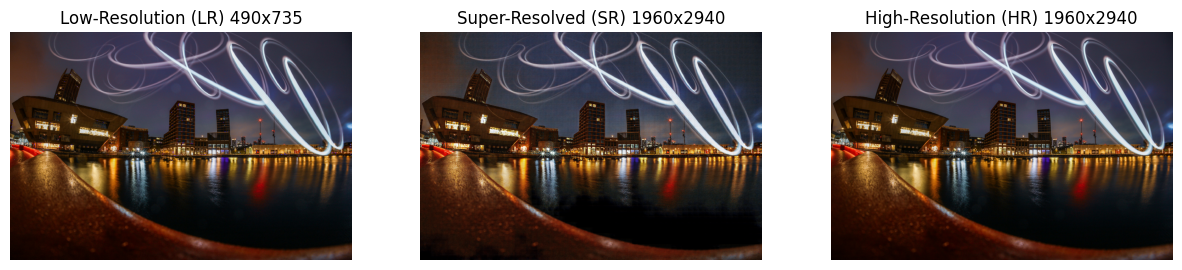

CPU times: user 4min 9s, sys: 1.98 s, total: 4min 11s
Wall time: 2min 7s


In [12]:
%%time

inference(model, "https://images.unsplash.com/photo-1734418265881-bf6efc0339e0?q=80&w=2940&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")